In [3]:
import numpy as np
import glob
import h5py

import matplotlib
matplotlib.use("Agg")

import matplotlib.pyplot as plt
%matplotlib inline

import gwpy
from gwpy import segments
from gwpy.timeseries import TimeSeries
from gwpy.timeseries import StateVector
import gwpy.astro

import json

from scipy.interpolate import interp1d
from astropy import cosmology, units as u
from pycbc.frame import StatusBuffer
from pycbc.frame import read_frame
from pycbc.filter import matched_filter, highpass, lowpass, sigma, resample_to_delta_t
from pycbc.psd import interpolate, inverse_spectrum_truncation, welch
from pycbc.types.frequencyseries import FrequencySeries

from pycbc.waveform import get_td_waveform, TemplateBank
from pycbc.detector import Detector
from pycbc.psd import interpolate

from tqdm import tqdm
# import ligo.skymap.plot

### Check state vector and load data

(1384782808, 1384782896, 88)


Strain Data of H1 in the segment (1384782808, 1384782896, 88) is loaded.
(1384782808, 1384782896, 88)
Strain Data of L1 in the segment (1384782808, 1384782896, 88) is loaded.


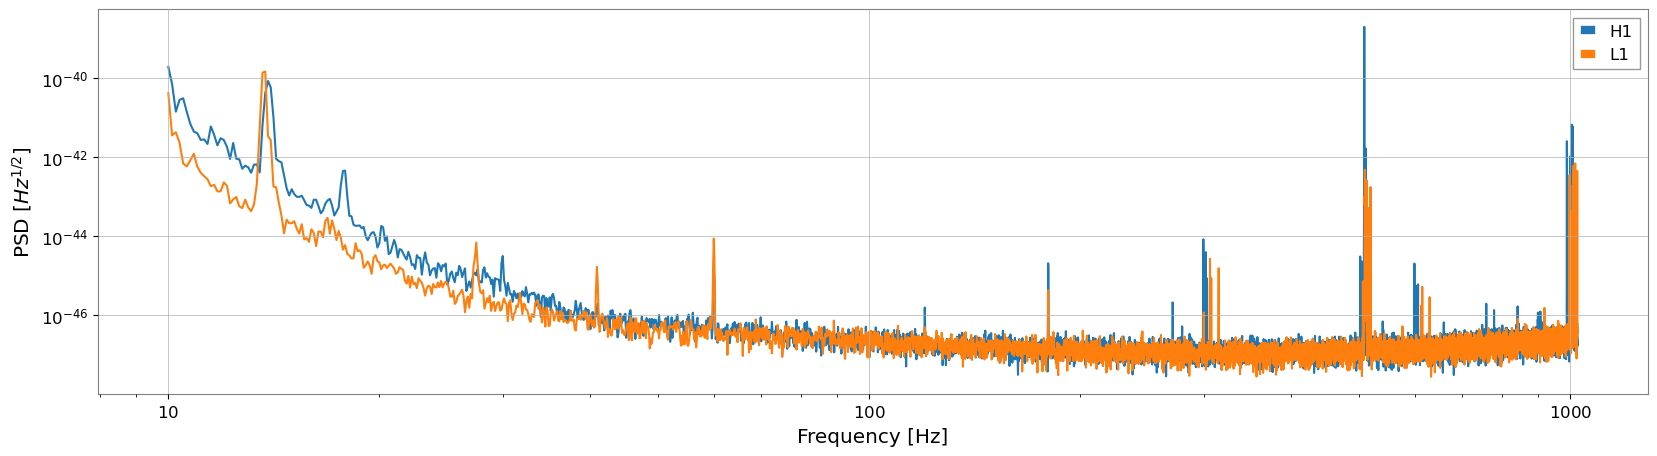

In [4]:
# Config
ifos = ["H1", "L1"]
ts_dict = dict.fromkeys(ifos)
psd_dict = dict.fromkeys(ifos)
for ifo in ifos:
    channels = [
        f"{ifo}:GDS-CALIB_STATE_VECTOR_AR",
        f"{ifo}:GDS-CALIB_STRAIN_CLEAN_AR",
    ]
    gps_time = 1384782888.7
    psd_length = 64
    before_trigger_length = psd_length + 16
    after_trigger_length = 8
    full_length = before_trigger_length + after_trigger_length
    start = int(gps_time) - before_trigger_length
    end = int(gps_time) + after_trigger_length
    duration = end - start
    print((start, end, duration))
    time_label = 138
    data_dir = f"/archive/frames/O4/hoft_C00_AR/{ifo}/{ifo[0]}-{ifo}_HOFT_C00_AR-{time_label}"
    source = glob.glob(f"{data_dir}/*.gwf")
    fftlength = 8
    overlap = 4
    window_length = 10

    # Check data quality and load data
    sv = StateVector.read(
        source=source,
        channel=channels[0],
        start=start,
        end=end,
    )
    bit_dict = sv.get_bit_series(bits=['Bit 0', 'Bit 1'])
    bit_series_0 = bit_dict['Bit 0']
    bit_series_1 = bit_dict['Bit 1']
    bit_check = (bit_series_0 * bit_series_1).all()
    if bit_check == True:
        gwpy_ts = TimeSeries.read(
            source=source,
            channel=channels[1],
            start=start,
            end=end,
        )
        ts_dict[ifo] = gwpy_ts.to_pycbc()
        print(f"Strain Data of {ifo} in the segment {(start, end, duration)} is loaded.")
    else:
        raise RuntimeError(f"Data Quality check faild for {ifo} data in the segment {(start, end, duration)}.")

    # Calculate PSD
    ts = ts_dict[ifo]
    psd_ts = ts.crop(0,full_length-psd_length)
    psd = psd_ts.psd(fftlength)
    psd_dict[ifo] = psd

flow, fhigh = 10, 1024
fst, fed = int(flow/psd.delta_f), int(fhigh/psd.delta_f)
plt.figure(figsize=[20,5])
for ifo in ifos:
    plt.plot(psd_dict[ifo].sample_frequencies[fst:fed], psd_dict[ifo][fst:fed], label=ifo)

plt.xlabel("Frequency [Hz]")
plt.ylabel(r"PSD [$Hz^{1/2}$]")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

### Template

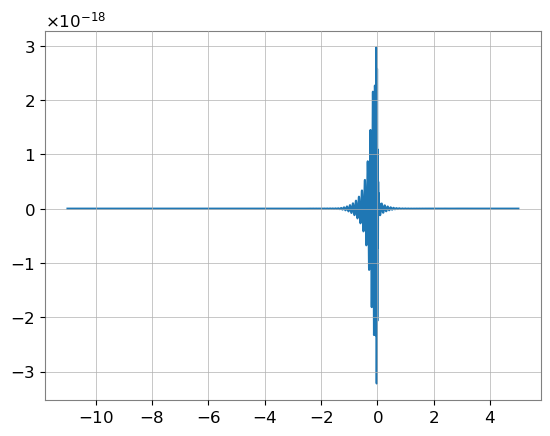

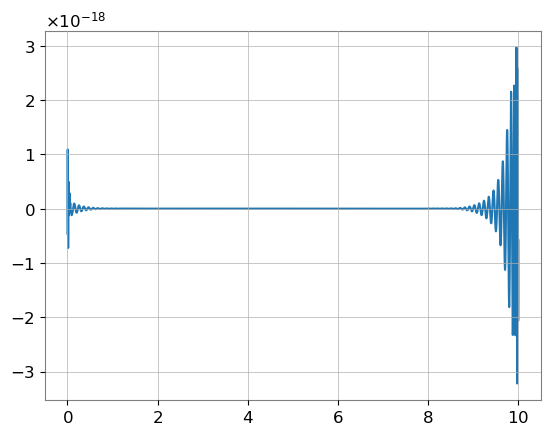

In [5]:
approximant = "SEOBNRv4_ROM"
mass1 = 222.21446
mass2 = 95.70826
spin1x = 0.0
spin1y = 0.0
spin1z = 0.0
spin2x = 0.0
spin2y = 0.0
spin2z = 0.0
sample_rate = 4096
f_lower = 10
hp, hc = get_td_waveform(
    approximant=approximant,
    mass1=mass1,
    mass2=mass2,
    spin1x=spin1x,
    spin1y=spin1y,
    spin1z=spin1z,
    spin2x=spin2x,
    spin2y=spin2y,
    spin2z=spin2z,
    delta_t=1/sample_rate,
    f_lower=f_lower,
)
plt.plot(hp.sample_times, hp)
plt.show()

# Cropping template to window_length
ini_template_ts = hp.copy()
st = ini_template_ts.sample_times[0]
ed = ini_template_ts.sample_times[-1]
if np.abs(st) < window_length/2:
    pad_num = int((window_length/2 - np.abs(st))*sample_rate)
    ini_template_ts.prepend_zeros(pad_num)
if np.abs(ed) < window_length/2:
    pad_num = int((window_length/2 - np.abs(ed))*sample_rate)
    ini_template_ts.append_zeros(pad_num)

st_crop = -window_length/2 - ini_template_ts.sample_times[0]
ed_crop = ini_template_ts.sample_times[-1] + 1/sample_rate - window_length/2
template_ts = ini_template_ts.crop(st_crop, ed_crop)
shifted_template_ts = template_ts.cyclic_time_shift(template_ts.start_time)
plt.plot(shifted_template_ts.sample_times, shifted_template_ts)
plt.show()

### Matched Filtering 1

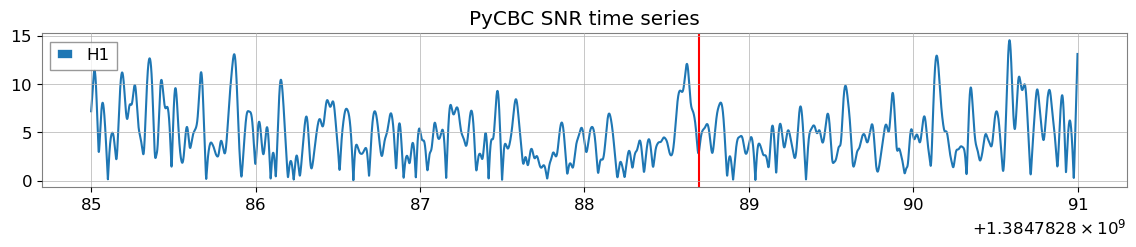

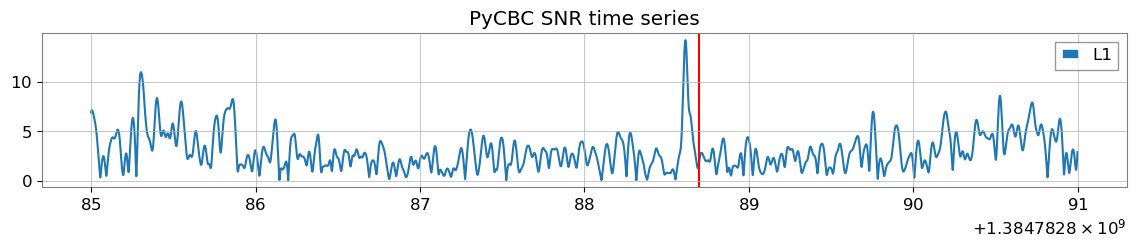

In [6]:
fmin = 10
low_frequency_cutoff = 10
snr_crop_length = 2
snr_dict = dict.fromkeys(ifos)
for ifo in ifos:
    # data conditioning
    data_ts = ts_dict[ifo].crop(full_length-2*after_trigger_length,0)
    data_ts = highpass(data_ts, fmin)
    data_ts = data_ts.resample(1/sample_rate)
    data_crop_length = (data_ts.duration - window_length)/2
    data_ts = data_ts.crop(data_crop_length, data_crop_length)
    psd = interpolate(psd_dict[ifo], data_ts.delta_f)

    # matched filtering
    snr_ts = matched_filter(
        shifted_template_ts,
        data_ts,
        psd=psd,
        low_frequency_cutoff=low_frequency_cutoff,
    )
    snr_dict[ifo] = snr_ts.crop(snr_crop_length, snr_crop_length)

    plt.figure(figsize=[14,2])
    plt.title("PyCBC SNR time series")
    plt.plot(snr_dict[ifo].sample_times, np.abs(snr_dict[ifo]), label=ifo)
    plt.axvline(gps_time, color='r')
    plt.legend()
    plt.show()


### Matched Filtering 2

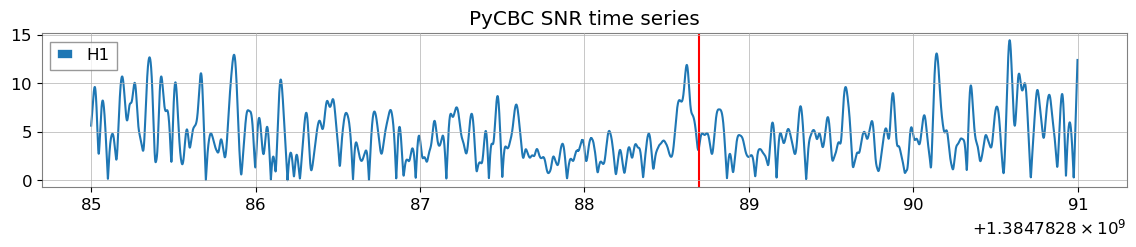

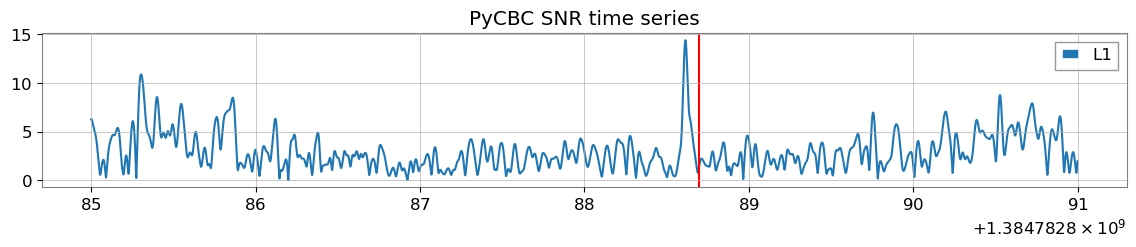

In [7]:
fmin = 10
low_frequency_cutoff = 10
whitening_crop_length = 3
snr_crop_length = 2
snr_dict = dict.fromkeys(ifos)
for ifo in ifos:
    # data conditioning
    data_ts = ts_dict[ifo].crop(full_length-2*after_trigger_length,0)
    data_ts = highpass(data_ts, fmin)
    data_ts = resample_to_delta_t(data_ts, 1/sample_rate)
    data_crop_length = (data_ts.duration - window_length)/2
    data_ts = data_ts.crop(data_crop_length, data_crop_length)

    data_spec = data_ts.to_frequencyseries()
    psd = psd_dict[ifo]
    psd_data = interpolate(psd, data_ts.delta_f)
    wh_data_spec = data_spec / psd_data[:len(data_spec)]**0.5
    # wh_data_spec = data_spec / psd_data[:len(data_spec)]
    wh_data_ts = wh_data_spec.to_timeseries()

    # whitening template
    template_spec = ini_template_ts.to_frequencyseries()
    psd_template = interpolate(psd, template_spec.delta_f)
    wh_template_spec = template_spec / psd_template[:len(template_spec)]**0.5
    # wh_template_spec = template_spec
    wh_template_ts = wh_template_spec.to_timeseries()
    st = wh_template_ts.sample_times[0]
    ed = wh_template_ts.sample_times[-1]
    if np.abs(st) < window_length/2:
        pad_num = int((window_length/2 - np.abs(st))*sample_rate)
        wh_template_ts.prepend_zeros(pad_num)
    if np.abs(ed) < window_length/2:
        pad_num = int((window_length/2 - np.abs(ed))*sample_rate)
        wh_template_ts.append_zeros(pad_num)

    st_crop = -window_length/2 - wh_template_ts.sample_times[0]
    ed_crop = wh_template_ts.sample_times[-1] + 1/sample_rate - window_length/2
    template_ts = wh_template_ts.crop(st_crop, ed_crop)
    shifted_template_ts = template_ts.cyclic_time_shift(template_ts.start_time)

    # plt.figure(figsize=[8,4])
    # plt.plot(wh_template_ts.sample_times, wh_template_ts, label="template")
    # plt.legend()
    # plt.show()
    # plt.figure(figsize=[8,4])
    # plt.plot(shifted_template_ts.sample_times, shifted_template_ts, label="whitened template")
    # plt.legend()
    # plt.show()

    # matched filtering
    snr_ts = matched_filter(
        shifted_template_ts,
        wh_data_ts,
        psd=None,
        low_frequency_cutoff=low_frequency_cutoff,
    )
    snr_dict[ifo] = snr_ts.crop(snr_crop_length, snr_crop_length)

    plt.figure(figsize=[14,2])
    plt.title("PyCBC SNR time series")
    plt.plot(snr_dict[ifo].sample_times, np.abs(snr_dict[ifo]), label=ifo)
    plt.axvline(gps_time, color='r')
    plt.legend()
    plt.show()


### Loding seqARIMA's PSD

In [9]:
def read_psd(filename, delimiter=" "):
    data = np.loadtxt(filename, delimiter=delimiter)
    freqs = data[:,0]
    value = data[:,1]

    fs = FrequencySeries(value, delta_f=freqs[1])

    return fs

In [11]:
psd_dir = "/home/chihyi.chang/data/beacon_data"
PSD_p4k = {}
PSD_p8k = {}
PSD_p8k_q3 = {}

for ifo in ifos:
    PSD_p4k[ifo] = read_psd(f"{psd_dir}/PSD_{ifo}_p4k.dat")
    PSD_p8k[ifo] = read_psd(f"{psd_dir}/PSD_{ifo}_p8k.dat")
    PSD_p8k_q3[ifo] = read_psd(f"{psd_dir}/PSD_{ifo}_p8k_q3.dat")

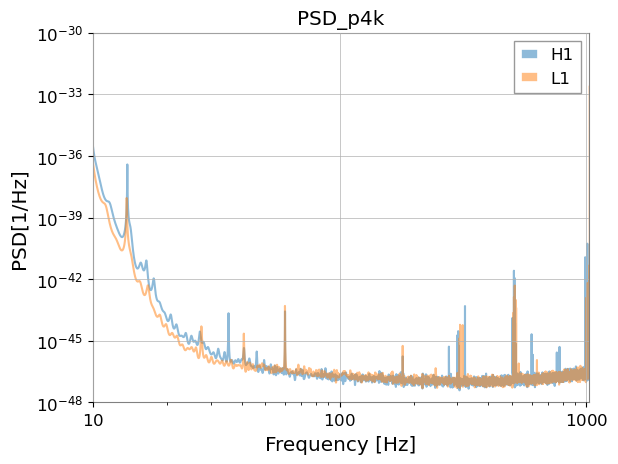

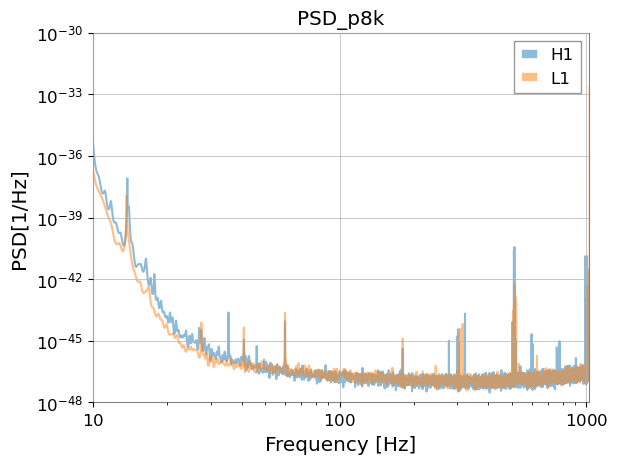

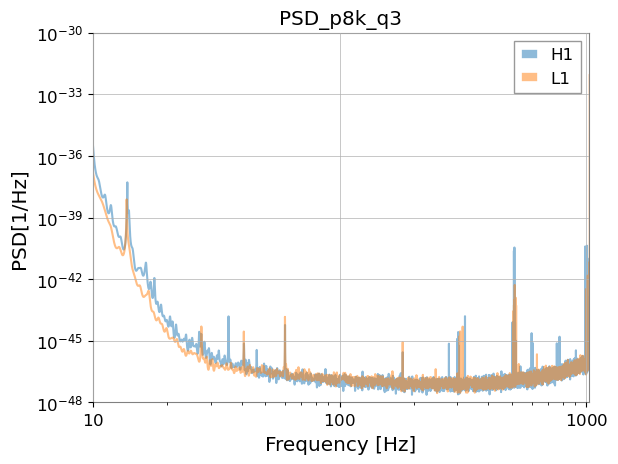

In [12]:
for ifo in ifos:
    plt.plot(PSD_p4k[ifo].sample_frequencies, PSD_p4k[ifo], label=ifo, alpha=0.5)
    plt.title("PSD_p4k")

    plt.xlim(10, 1024)
    plt.ylim(1e-48, 1e-30)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD[1/Hz]')
    plt.legend()
plt.show()

for ifo in ifos:
    plt.plot(PSD_p8k[ifo].sample_frequencies, PSD_p8k[ifo], label=ifo, alpha=0.5)
    plt.title("PSD_p8k")

    plt.xlim(10, 1024)
    plt.ylim(1e-48, 1e-30)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD[1/Hz]')
    plt.legend()
plt.show()

for ifo in ifos:
    plt.plot(PSD_p8k_q3[ifo].sample_frequencies, PSD_p8k_q3[ifo], label=ifo, alpha=0.5)
    plt.title("PSD_p8k_q3")

    plt.xlim(10, 1024)
    plt.ylim(1e-48, 1e-30)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD[1/Hz]')
    plt.legend()
plt.show()


### Download Raw Data

In [ ]:
def check_statevector(
    source_dict: dict,
    channel_dict: dict,
    start: float,
    end: float,
):
    ifos = list(source_dict.keys())
    dq_check_results = dict.fromkeys(ifos)
    for ifo in ifos:
        if source is None:
            continue
        else:
            sv = StateVector.read(
                source=source,
                channel=channel_dict[ifo],
                start=start,
                end=end,
            )
            if ifo == "H1" or "L1":
                bit_dict = sv.get_bit_series(
                    bits=['Bit 0', 'Bit 1']
                )
                bit_series_0 = bit_dict['Bit 0']
                bit_series_1 = bit_dict['Bit 1']
                bit_check = (bit_series_0 * bit_series_1).all()
            if ifo == "V1":
                bit_dict = sv.get_bit_series(
                    bits=['Bit 0', 'Bit 1', 'Bit 10']
                )
                bit_series_0 = bit_dict['Bit 0']
                bit_series_1 = bit_dict['Bit 1']
                bit_series_10 = bit_dict['Bit 10']
                bit_check = (bit_series_0 * bit_series_1 * bit_sereis_10).all()
            if ifo == "K1":
                bit_dict = sv.get_bit_series(
                    bits=['Bit 0']
                )
                bit_series_0 = bit_dict['Bit 0']
                bit_check = (bit_series_0).all()
            dq_check_results[ifo] = bit_check

    return dq_check_results

def get_data(
    source_dict: dict,
    channel_dict: dict,
    start: float,
    end: float,
):
    ifos = list(source_dict.keys())
    ts_dict = dict.fromkeys(ifos)
    for ifo in ifos:
        ts = TimeSeries.read(
            source=source_dict[ifo],
            channel=channel_dict[ifo],
            start=start,
            end=end,
        )
        ts_dict[ifo] = ts

    return ts_dict

In [ ]:
dq_channel_dict = {
    "H1": "H1:GDS-CAL_STATE_VECTOR_AR",
    "L1": "L1:GDS-CAL_STATE_VECTOR_AR",
    "V1": "V1:DQ_ANALYSIS_STATE_VECTOR",
    "K1": "K1:CAL-STATE_VECTOR_C00",
}
strain_channel_dict = {
    "H1": "H1:GDS-CAL_STRAIN_AR",
    "L1": "L1:GDS-CAL_STRAIN_AR",
    "V1": "V1:Hrec_hoftRepro1AR_16384Hz",
    "K1": "K1:GRD-CAL_STRAIN_C00",

event_time = 1440584675.73 
start = int(event_time - 10)
end = int(event_time + 10) 
H1_data_dir = "/archive/frames/O4/hoft_C00_AR/H1/H-H1_HOFT_C00_AR-144"
H1_source = glob.glob(f"{data_dir}/*.gwf")
H1_source = sorted(H1_source)
L1_data_dir = "/archive/frames/O4/hoft_C00_AR/L1/L-L1_HOFT_C00_AR-144"
L1_source = glob.glob(f"{data_dir}/*.gwf")
L1_source = sorted(L1_source)

source_dict = {
    "H1": H1_source,
    "L1": L1_source,
    "V1": None,
    "K1": None,
}
}

In [29]:
check_statevector(
    source_dict=source_dict,
    channel_dict=dq_channel_dict,
    start=start,
    end=end,
)

RecursionError: maximum recursion depth exceeded while calling a Python object

### Bayestar

In [ ]:
# Use bayestar to calculate the skymap.
event_id = "0"
"bayestar-localize-coincs {event_id}.xml {event_id}.xml"

# Plot the skymap.
f"ligo-skymap-plot {event_id}.fits -o output.png"